In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:

# ID du Google Sheet et GID de l'onglet
sheet_id = "1PdnadzZswADLqGBrI53a_8IsegivCMSz1pCZOh384-Y"
gid = "1517184233"

# Construction du lien CSV public de Google Sheets
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

# Lecture du CSV directement dans un DataFrame
df = pd.read_csv(url)

# Si ton tableau commence à la colonne D (donc avec des colonnes vides avant),
# on peut supprimer les colonnes vides automatiquement :
df = df.dropna(axis=1, how="all")
df = df.replace("-", np.nan)
df = df.dropna(subset=['Team Gap Early', 'Est. Win'])

In [3]:
# ==========================
# PARAMÈTRES GÉNÉRAUX
# ==========================
features = ["Team Gap Early", "R", "Perf relative", "Perf intrinsèque"]
target_col = "Team Gap Early"
max_lag = 7

# ==========================
#  MISE EN FORME DU DATASET
# ==========================
for c in df.columns:
    df[c] = df[c].astype(str).str.replace(",", ".")
    df[c] = pd.to_numeric(df[c], errors="coerce")

# ---- Création des colonnes de lag ----
for feat in features:
    for lag in range(1, max_lag + 1):
        df[f"{feat}_lag{lag}"] = df[feat].shift(lag)

df = df.dropna(subset=[target_col])

# ==========================
# OPTIMISATION DU TAUX DE DÉCROISSANCE
# En temps noomal, on souhaiterai que notre modele apprene le taux de decroissance de lui meme mais on a pas assez de donnee
# On va donc forcer des poids decroissant pour coller a notre intuition du score
# ==========================
def objective(lmbda):
    decay = np.exp(-lmbda * np.arange(1, max_lag + 1))
    decay /= decay.sum()
    
    df_temp = df.copy()
    for feat in features:
        lag_cols = [f"{feat}_lag{i}" for i in range(1, max_lag + 1)]
        df_temp[f"{feat}_weighted"] = df_temp[lag_cols].fillna(0).dot(decay)
    
    X = df_temp[[f"{feat}_weighted" for feat in features]].values
    y = df_temp[target_col].values
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    model = Ridge(alpha=1.0)
    model.fit(X_scaled, y)
    
    return -r2_score(y, model.predict(X))

res = minimize(objective, x0=[0.3], bounds=[(0.05, 1.0)])
best_lambda = res.x[0]
print(f" Lambda optimal trouvé : {best_lambda:.4f}")

# ==========================
# RE-ENTRAÎNEMENT FINAL
# On entraine le modele avec le taux de decroissance des poids pour la lag qui augment
# ==========================
decay = np.exp(-best_lambda * np.arange(1, max_lag + 1))
decay /= decay.sum()

for feat in features:
    lag_cols = [f"{feat}_lag{i}" for i in range(1, max_lag + 1)]
    df[f"{feat}_weighted"] = df[lag_cols].fillna(0).dot(decay)

X = df[[f"{feat}_weighted" for feat in features]].values
y = df[target_col].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = Ridge(alpha=0.7)
model.fit(X_scaled, y)

coefs = model.coef_
intercept = model.intercept_

coef_df = pd.DataFrame({
    "Feature": features,
    "Poids": coefs
}).round(4)

print("\n Poids globaux par feature :")
print(coef_df)
print(f"\nIntercept : {intercept:.4f}")

y_pred = model.predict(X_scaled)
print(f"\nR² (train) : {r2_score(y, y_pred):.3f}")
print(f"MAE (train) : {mean_absolute_error(y, y_pred):.3f}")

print(f"\nDécroissance exponentielle utilisée (λ = {best_lambda:.3f}) :")
print(np.round(decay, 4))

# ==========================
# CALCUL DES POIDS EFFECTIFS PAR LAG
# ==========================
# produit w_feature × decay_lag pour chaque feature et lag
weights_matrix = np.outer(coefs, decay)
weights_df = pd.DataFrame(
    weights_matrix,
    index=features,
    columns=[f"lag{i}" for i in range(1, max_lag + 1)]
).round(5)

print("\n------------ Poids effectifs (w_feature × λ_lag) :")
print(weights_df)



 Lambda optimal trouvé : 1.0000

 Poids globaux par feature :
            Feature   Poids
0    Team Gap Early -1.2964
1                 R  1.1306
2     Perf relative -0.1921
3  Perf intrinsèque  0.6416

Intercept : 0.2222

R² (train) : 0.440
MAE (train) : 0.967

Décroissance exponentielle utilisée (λ = 1.000) :
[0.6327 0.2328 0.0856 0.0315 0.0116 0.0043 0.0016]

------------ Poids effectifs (w_feature × λ_lag) :
                     lag1     lag2     lag3     lag4     lag5     lag6  \
Team Gap Early   -0.82020 -0.30174 -0.11100 -0.04084 -0.01502 -0.00553   
R                 0.71530  0.26314  0.09680  0.03561  0.01310  0.00482   
Perf relative    -0.12151 -0.04470 -0.01644 -0.00605 -0.00223 -0.00082   
Perf intrinsèque  0.40593  0.14933  0.05494  0.02021  0.00743  0.00274   

                     lag7  
Team Gap Early   -0.00203  
R                 0.00177  
Perf relative    -0.00030  
Perf intrinsèque  0.00101  


In [4]:
def generate_excel_formula(row, decay, coefs, intercept, start_row=2):

    features_letters = ["F", "G", "H", "I"]  # ordre : Team Gap Early, R, Perf relative, Perf intrinsèque
    
    inner = f"({intercept:.4f}".replace(".", ",")

    for feat_idx, col_letter in enumerate(features_letters):
        coef = coefs[feat_idx]
        inner += f"+({coef:.4f})*SOMMEPROD(("
        
        for lag_idx, d in enumerate(decay):
            lag_row = row - (lag_idx + 1)
            inner += f"{d:.4f}*{col_letter}{lag_row}+"
        
        inner = inner.rstrip("+") + "))"
    
    inner += ")"  # fermeture de la formule interne
    
    # Application du mapping linéaire : 20 + (score + 2) * 15
    formula = f"=20+({inner}+2)*15"
    
    formula = formula.replace(".", ",")
    return formula

row_number = 9
excel_formula_row9 = generate_excel_formula(row_number, decay, coefs, intercept)
print(excel_formula_row9)

=20+((0,2222+(-1,2964)*SOMMEPROD((0,6327*F8+0,2328*F7+0,0856*F6+0,0315*F5+0,0116*F4+0,0043*F3+0,0016*F2))+(1,1306)*SOMMEPROD((0,6327*G8+0,2328*G7+0,0856*G6+0,0315*G5+0,0116*G4+0,0043*G3+0,0016*G2))+(-0,1921)*SOMMEPROD((0,6327*H8+0,2328*H7+0,0856*H6+0,0315*H5+0,0116*H4+0,0043*H3+0,0016*H2))+(0,6416)*SOMMEPROD((0,6327*I8+0,2328*I7+0,0856*I6+0,0315*I5+0,0116*I4+0,0043*I3+0,0016*I2)))+2)*15


**ATTENTION** : cette formule fait une prédiction entre 20 ET 80 pour le **TEAM GAP EARLY**, pas une prédiction sur la WIN. (on peut le changer)
- Actuellement cette formule est pour la ligne 9 puis il faut la faire glisser sur les autres cases après


Bonus matrice de corrélation

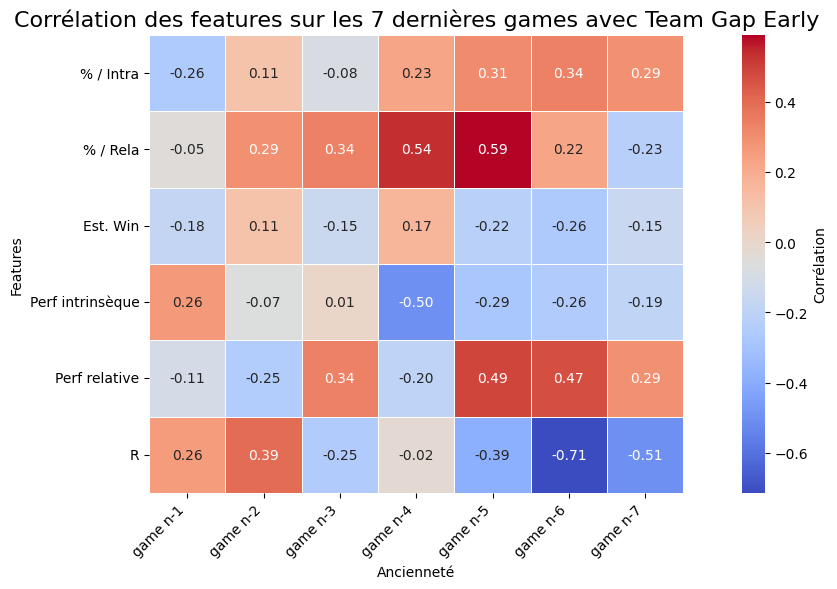

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features = ['R', 'Perf relative', 'Perf intrinsèque', 'Team Gap Early']
target = 'Team Gap Early'
max_lag = 7

df_lagged = df.copy()

# Créer les colonnes lag
for feat in features:
    for lag in range(1, max_lag + 1):
        df_lagged[f'{feat}_lag{lag}'] = df_lagged[feat].shift(lag)

# Supprimer les lignes avec target NaN
df_corr = df_lagged.dropna(subset=[target])

# Calcul des corrélations
corr_dict = {}
for feat in features:
    for lag in range(1, max_lag + 1):
        corr_dict[f'{feat}_lag{lag}'] = df_corr[target].corr(df_corr[f'{feat}_lag{lag}'])

corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['Correlation'])
corr_df['Feature'] = [name.split('_lag')[0] for name in corr_df.index]
corr_df['Lag'] = [int(name.split('_lag')[1]) for name in corr_df.index]

# Pivot pour heatmap
heatmap_data = corr_df.pivot(index='Feature', columns='Lag', values='Correlation')

# Heatmap avec labels
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Corrélation'},
    linewidths=0.5,
    square=True
)

# Forcer les labels pour toutes les cases
ax.set_xticklabels([f"game n-{i}" for i in heatmap_data.columns], rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=10)

plt.title('Corrélation des features sur les 7 dernières games avec Team Gap Early', fontsize=16)
plt.xlabel('Ancienneté')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
